In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from swdb_2018_neuropixels.ephys_nwb_adapter import NWB_adapter    

In [3]:
drive_path = '/data/dynamic-brain-workshop/visual_coding_neuropixels'

In [4]:
manifest_file = os.path.join(drive_path,'ephys_manifest.csv')
expt_info_df = pd.read_csv(manifest_file)
multi_probe_expt_info = expt_info_df[expt_info_df.experiment_type == 'multi_probe']
multi_probe_example = 1 # index to row in multi_probe_expt_info
multi_probe_filename  = multi_probe_expt_info.iloc[multi_probe_example]['nwb_filename']
nwb_file = os.path.join(drive_path,multi_probe_filename)
data_set = NWB_adapter(nwb_file)

In [5]:
# load all dataset objects
data_set_all=[]
for i in range(len(expt_info_df)): # index to row in multi_probe_expt_info
    expt_filename  = expt_info_df.iloc[i]['nwb_filename']
    # iloc allows you to access particular rows of dataset
    print expt_filename

    # Specify full path to the .nwb file
    nwb_file = os.path.join(drive_path, expt_filename)

    data_set_all.append(NWB_adapter(nwb_file)) # this linetakes a while
    
    print(data_set_all[i].number_cells)  #"tab completion"


# aggregate all unit dataframe 
for i in range(len(expt_info_df)): # index to row in multi_probe_expt_info
    unit_df_subset=data_set_all[i].unit_df.copy()
    pds0=pd.Series([i] * unit_df_subset.shape[0])
    unit_df_subset=unit_df_subset.assign(data_set_ind = pds0.values)
    pds1=pd.Series([expt_info_df.iloc[i]['nwb_filename']] * unit_df_subset.shape[0])
    unit_df_subset=unit_df_subset.assign(nwb_filename = pds1.values)
    if i==0:
        unit_df_all=unit_df_subset
    else:
        unit_df_all=unit_df_all.append(unit_df_subset)

if 'index' not in unit_df_all.keys():
    unit_df_all=unit_df_all.reset_index() #(drop=True)


# aggregate all spike waveforms 
spike_waveforms_all=[] # empty list
for i in range(len(expt_info_df)): 
    spike_waveforms_all.append( data_set_all[i].get_waveforms() )

spikewf_all=np.zeros([unit_df_all.shape[0], 82])
spikewftrough_all=np.zeros([unit_df_all.shape[0], 1])   
spikewfpeak_all=np.zeros([unit_df_all.shape[0], 1])   
for i in range(unit_df_all.shape[0]):
    whichdataset = unit_df_all['data_set_ind'][i]
    whichprobe = unit_df_all['probe'][i]
    whichunit = unit_df_all['unit_id'][i]
    
    if whichprobe == 'V1':
        spikewf_all[i,:]=np.nan
        spikewftrough_all[i]=np.nan
        spikewfpeak_all[i]=np.nan       
    else:
        spikewf_all[i,:]=spike_waveforms_all[whichdataset][whichprobe][whichunit]
        spikewftrough_all[i]=spike_waveforms_all[whichdataset][whichprobe][whichunit].argmin()
        spikewfpeak_all[i]=spike_waveforms_all[whichdataset][whichprobe][whichunit].argmax()


if 'RSFS' not in unit_df_all.keys():
    spikewfp2t=(spikewfpeak_all-spikewftrough_all)/30.
    rsfs=np.array(['SU']*unit_df_all.shape[0])
    rsinds,_=np.where(spikewfp2t>0.4)
    rsfs[rsinds]='RS'
    fsinds,_=np.where(spikewfp2t<=0.4)
    rsfs[fsinds]='FS'
    srsfs=pd.Series(rsfs)
    unit_df_all=unit_df_all.assign(RSFS = srsfs.values)
    print(unit_df_all.keys())


# aggregate all spike time in the same order as unit_df_all
spike_times_all=[] # empty list
for i in range(unit_df_all.shape[0]):
    whichdataset = unit_df_all['data_set_ind'][i]
    whichprobe = unit_df_all['probe'][i]
    whichunit = unit_df_all['unit_id'][i]
    spike_times_all.append(data_set_all[whichdataset].spike_times[whichprobe][whichunit])


ephys_single_14.nwb
{'V1': 66}
ephys_single_15.nwb
{'V1': 49}
ephys_single_16.nwb
{'V1': 69}
ephys_single_39.nwb
{'V1': 47}
ephys_single_51.nwb
{'V1': 47}
ephys_multi_84.nwb
{'probeD': 91, 'probeE': 169, 'probeF': 123, 'probeA': 39, 'probeB': 218, 'probeC': 99}
ephys_multi_58.nwb
{'probeD': 181, 'probeE': 194, 'probeF': 56, 'probeA': 178, 'probeB': 286, 'probeC': 307}
ephys_multi_10.nwb
{'probeD': 157, 'probeE': 221, 'probeF': 160, 'probeA': 222, 'probeB': 173, 'probeC': 236}
ephys_multi_21.nwb
{'probeD': 90, 'probeA': 109, 'probeB': 106, 'probeC': 178}
Index([u'index', u'unit_id', u'probe', u'structure', u'snr', u'depth',
       u'channel', u'data_set_ind', u'nwb_filename', u'RSFS'],
      dtype='object')


/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in greater
/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/__main__.py:60: RuntimeWarning: invalid value encountered in less_equal


In [6]:
nwb_file = 'ephys_multi_58.nwb'
unit_df = unit_df_all[unit_df_all.nwb_filename==nwb_file]
data_set.unit_df = unit_df

In [7]:
from downsampling_module import downsample_images

In [8]:
nat_scenes = np.load('natural_scenes.npy')

In [9]:
ds_nat_scenes = np.array(downsample_images(nat_scenes, 25, 25))
ds_nat_scenes = ds_nat_scenes*(1.0/255.0)

(118, 36, 46)


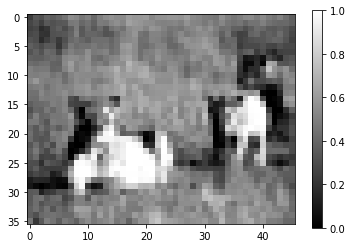

In [10]:
print(ds_nat_scenes.shape)
plt.imshow(ds_nat_scenes[7], cmap='gray')
plt.colorbar()

In [11]:
from downsampling_module import flatten_images

In [12]:
flattened_image_list = flatten_images(np.array(ds_nat_scenes))

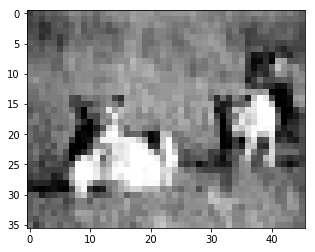

In [13]:
plt.imshow(flattened_image_list[7].reshape(36,46), cmap='gray')

In [14]:
stim_table = data_set.get_stimulus_table('natural_scenes')

In [15]:
def get_frame_at_time(time, stim_table):
    starts = stim_table.start.values
    idx = np.searchsorted(starts, time)-1
    return(stim_table.iloc[idx].values[2])

In [16]:
def get_stim_time_array(stim_table, tns_start, tns_end, bin_len, flattened_image_list):
    T = int(np.floor((tns_end - tns_start)/bin_len))
    time_array = np.linspace(tns_start,tns_end,T)
    stim_array = []
    for idx, time_point in enumerate(time_array):
        stim_index = get_frame_at_time(time_point, stim_table)
        stim_array.append(flattened_image_list[int(stim_index)])
    return(stim_array, time_array)

# def get_stim_time_arrays_imgs(stim_table, bin_len, flattened_image_list, imgs, nums):
#     time_arrays = []
#     stim_arrays = []
#     for num in nums:
#         stim_array = []
#         for img in imgs:
#             for i in range(num):   
    

(97,)


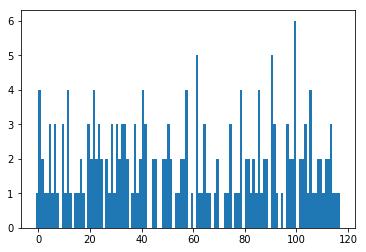

In [17]:
print np.unique(stim_table.frame.values[:200]).shape
a = plt.hist(stim_table.frame.values[:200],bins=118)

In [40]:
bin_len = 0.001
num_stim_rows = 300
imgs = np.unique(stim_table.frame.values[:num_stim_rows])
print len(imgs)
tns_start = stim_table.iloc[0].values[0]
tns_end = stim_table.iloc[num_stim_rows].values[1]
print(tns_start)
print(tns_end)

112
5908.725920000001
5984.037139999999


In [41]:
[stim_array, time_array] = get_stim_time_array(stim_table,tns_start,tns_end,bin_len,flattened_image_list)
print(tns_start)
print(tns_end)

5908.725920000001
5984.037139999999


In [42]:
print(np.shape(stim_array))

print(np.shape(time_array))


(75311, 1656)
(75311,)


In [43]:
# print(time_array.shape)
# print(np.array(stim_array).shape)

# time_array_short = time_array[0:len(time_array)/4]
# stim_array_short = stim_array[:,:len(time_array)/4]
# print(time_array_short.shape)
# print(np.array(stim_array_short).shape)

tns_start = time_array[0]
tns_end = time_array[-1]
print(tns_start)
print(tns_end)

print(time_array.shape)


5908.725920000001
5984.037139999999
(75311,)


In [44]:
def bin_spikes(data_set,bin_len,t_start,t_final,probes=None,regions=None):
    if probes is None:
        probes = data_set.probe_list
    if regions is None:
        regions = data_set.unit_df.structure.unique()
    
    #gather cells from desired regions and probes into cell_table
    use_cells = False
    for probe in probes:
        for region in regions:
            use_cells |= (data_set.unit_df.probe==probe) & (data_set.unit_df.structure==region)
    cell_table = data_set.unit_df[use_cells]
    
    N = len(cell_table)     #number of cells
    T = int(np.floor((t_final-t_start)/bin_len)) #number of time bins
    binned_spikes = np.zeros((N,T)) # binned_spikes[i,j] is the number of spikes from neuron i in time bin j

    #for each cell in the table, add each spike to the appropriate bin
    i = 0
    for z,cell in cell_table.iterrows(): 
        for spike_time in data_set.spike_times[cell['probe']][cell['unit_id']]:
            t = int(np.floor((spike_time-t_start)/bin_len))
            if (t >=0) & (t<T):
                binned_spikes[i,t] += 1
        i+=1    
    return (binned_spikes, cell_table)

In [45]:
(binned_spikes, cell_table) = bin_spikes(data_set,bin_len,tns_start,tns_end,regions=['VISp'])

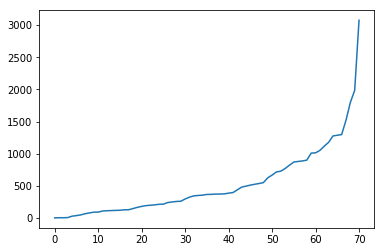

In [78]:
k = 25
cell_idxs = np.argsort(binned_spikes.sum(axis=1))
reduced_binned_spikes = binned_spikes[cell_idxs[-k:],:]
plt.plot(binned_spikes.sum(axis=1)[cell_idxs])

In [79]:
reduced_binned_spikes.shape

(25, 75311)

In [80]:
def construct_GLM_mat(flat_stimulus, binned_spikes, d_stim, d_spk):
    (N,T) = binned_spikes.shape # N is number of neurons, T is number of time bins
    (M,T) = flat_stimulus.shape # M is the size of a stimulus
#     print("N,T", (N,T))
#     print("M,T", (M,T))
    X_dsn = np.empty((T-d_stim,M*d_stim+N*d_spk))
    d_max = max(d_stim,d_spk)
    for t in range(T-d_max):
        X_dsn[t,:M*d_stim] = np.fliplr(flat_stimulus[:,t+d_max-d_stim:t+d_max]).reshape((1,-1))  #stimulus inputs
        X_dsn[t,M*d_stim:] = np.fliplr(binned_spikes[:,t+d_max-d_spk:t+d_max]).reshape((1,-1)) #spike inputs
    return X_dsn    


In [81]:
cell_types = []
sign_map = {'FS':'exc', 'RS':'inh'}
for c_idx in cell_idxs[-k:]:
    c_type = ''
    c_type += sign_map[cell_table.RSFS.values[c_idx]] + '_'
    c_type += cell_table.structure.values[c_idx] + '_'
    if str.startswith(cell_table.structure.values[c_idx],'VIS'):
        if cell_table.depth.values[c_idx] > -920:
            c_type += '1'
        elif cell_table.depth.values[c_idx] > -960:
            c_type += '4'
        else:
            c_type += '5'
    cell_types.append(c_type)
print len(cell_types), np.unique(cell_types)

25 ['exc_VISp_1' 'exc_VISp_5' 'inh_VISp_1' 'inh_VISp_4' 'inh_VISp_5']


In [82]:
priors = {}
ncomp=2
for c_type in np.unique(cell_types):
    priors[c_type] = np.load(c_type+'GMM_'+str(ncomp)+'comp.npz')

In [83]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras import Sequential
from keras.layers import Dense, Lambda
from keras.regularizers import Regularizer
from keras.callbacks import ModelCheckpoint
from keras.regularizers import Regularizer



class GroupAndPriors(Regularizer):
    """Regularizer for group lasso regularization.
    # Arguments
       l1: Float; L1 regularization factor.
       l2: Float; L2 group regularization factor.
   """

    def __init__(self, size_stim, d_spike, prior = None, i=None, lprior = 0, lgroup = 0.):
        self.lgroup = K.cast_to_floatx(lgroup)
        if prior is not None:
            self.lprior = K.cast_to_floatx(lprior)
            self.i = i
            self.W_means = prior['W_means']
            self.W_vars = prior['W_vars']
            self.W_weights = prior['W_weights']
            self.lsmooth = K.cast_to_floatx(1.0*lprior) #fudge factor here to account for relationship between priors
        else:
            self.lprior = 0
            
        self.d_spike = d_spike
        self.size_stim = size_stim

    def __call__(self, x): 
        xr = K.reshape(x[self.size_stim:], (-1, self.d_spike))
        pen = 0.
        if self.lgroup > 0:
            pen += self.lgroup * np.sqrt(K.int_shape(xr)[1])*K.sum(K.sqrt(K.sum(K.square(xr),axis=1)))
        if self.lprior > 0:
            pen += self.lprior * K.sum(-K.log(K.epsilon()+K.sum(self.W_weights*K.exp(-0.5*K.square(K.repeat_elements(K.expand_dims(xr[self.i,:],axis=0),self.W_means.shape[0],0)-self.W_means)/self.W_vars),axis=0)))
        if self.lsmooth > 0:
            pen += self.lsmooth * K.sum(K.square(xr[self.i,:-1]-xr[self.i,1:]))
        return pen
    
class BiasPrior(Regularizer):
    """Regularizer for group lasso regularization.
    # Arguments
       l1: Float; L1 regularization factor.
       l2: Float; L2 group regularization factor.
   """

    def __init__(self, prior = None, lprior = 0):
        if prior is not None:
            self.lprior = K.cast_to_floatx(lprior)
            self.b_mean = prior['b_mean']
            self.b_std = prior['b_std']            
        else:
            self.lprior = 0


    def __call__(self, x): 
        return self.lprior * K.square((x-self.b_mean)/self.b_std)



In [84]:
# tells keras not to use the GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

from keras.callbacks import LearningRateScheduler

def exp_decay(t):
    initial_lrate = 5e-1
    k = 0.9
    lrate = initial_lrate * k**t
    return lrate

# Inputs:
# stimulus: video shown to the mouse in some form (M pixels x T time points)
# spikes: spikes recorded from each neuron in some form (N neurons x T time points)
# d_stim: length of stimulus filters in samples
# d_spk: length of spike filters in samples
# f: string for the firing rate function used. options are {'exp'}
# priors: a dictionary of dictionaries, mapping a cell type (string of form '<inh or exc>_<region>_<layer>') to a prior (dictionary with keys 'W_means', 'W_vars', 'W_weights' corresponding to GMM parameters)
# cell_types: a list of the cell types for each cell (string of form  '<inh or exc>_<region>_<layer>')

def GLM_network_fit(stimulus,spikes,d_stim, d_spk,bin_len,f='exp',priors=None,cell_types=None):
    N = spikes.shape[0]
#     print("N", N)
    M = stimulus.shape[0]
#     print("M", M)
    F = np.empty((N,M,d_stim)) # stimulus filters
    W = np.empty((N,N,d_spk))  # spike train filters
    b = np.empty((N,)) # biases
    losses = np.empty((N,))
    models = []
    fs = {'exp':K.exp}
    Xdsn = construct_GLM_mat(stimulus,spikes, d_stim, d_spk)
    for i in range(N):
        y = spikes[i,max(d_stim,d_spk):]
        # construct GLM model and return fit
        model = Sequential()
        model.add(Dense(1,input_dim = Xdsn.shape[1],use_bias=True,
                        kernel_regularizer=GroupAndPriors(M*d_stim,d_spk,lgroup=0,lprior = 1e-5,prior=priors[cell_types[i]],i=i),
                        kernel_initializer=keras.initializers.RandomUniform(minval=np.min(priors[cell_types[i]]['W_means'][0,:]-2*np.sqrt(priors[cell_types[i]]['W_vars'][0,:])),maxval=np.max(priors[cell_types[i]]['W_means'][-1,:]+2*np.sqrt(priors[cell_types[i]]['W_vars'][-1,:]))),
                        bias_regularizer=BiasPrior(prior=priors[cell_types[i]],lprior=1e-5),
                        bias_initializer=keras.initializers.RandomNormal(mean=priors[cell_types[i]]['b_mean'],stddev=priors[cell_types[i]]['b_std'])
                       ))
        model.add(Lambda(lambda x: fs[f](x)*bin_len))
        model.compile(loss = 'poisson',optimizer = keras.optimizers.adam(lr=5e-1))
#        checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=False)
        model.fit(x=Xdsn,y=y,batch_size=5000,epochs=5,verbose=2,callbacks=[LearningRateScheduler(exp_decay)])
        p = model.get_weights()[0]
        F[i,:,:] = p[:M*d_stim].reshape((M,d_stim))
        W[i,:,:] = p[M*d_stim:].reshape((N,d_spk))
        b[i] = model.get_weights()[1]
#         losses[i] = model.evaluate(x=Xdsn,y=y,verbose=0)
        models.append(model)
    return (F,W,b,losses,models)


In [85]:
d = 40
(F, W, b, losses, models) = GLM_network_fit(np.array(stim_array).T,reduced_binned_spikes,d,d, bin_len,priors=priors, cell_types=cell_types)


Epoch 1/5
 - 54s - loss: 0.1160
Epoch 2/5
 - 53s - loss: 0.1133
Epoch 3/5
 - 53s - loss: 0.1129
Epoch 4/5
 - 53s - loss: 0.1126
Epoch 5/5
 - 53s - loss: 0.1126
Epoch 1/5
 - 54s - loss: 0.1186
Epoch 2/5
 - 53s - loss: 0.1154
Epoch 3/5
 - 53s - loss: 0.1149
Epoch 4/5
 - 53s - loss: 0.1148
Epoch 5/5
 - 53s - loss: 0.1148
Epoch 1/5
 - 54s - loss: 0.1214
Epoch 2/5
 - 53s - loss: 0.1186
Epoch 3/5
 - 53s - loss: 0.1182
Epoch 4/5
 - 53s - loss: 0.1181
Epoch 5/5
 - 53s - loss: 0.1179
Epoch 1/5
 - 54s - loss: 0.1373
Epoch 2/5
 - 53s - loss: 0.1348
Epoch 3/5
 - 53s - loss: 0.1344
Epoch 4/5
 - 53s - loss: 0.1343
Epoch 5/5
 - 53s - loss: 0.1343
Epoch 1/5
 - 54s - loss: 0.1466
Epoch 2/5
 - 53s - loss: 0.1438
Epoch 3/5
 - 53s - loss: 0.1434
Epoch 4/5
 - 53s - loss: 0.1433
Epoch 5/5
 - 53s - loss: 0.1433
Epoch 1/5
 - 54s - loss: 0.1558
Epoch 2/5
 - 53s - loss: 0.1540
Epoch 3/5
 - 53s - loss: 0.1537
Epoch 4/5
 - 53s - loss: 0.1537
Epoch 5/5
 - 53s - loss: 0.1537
Epoch 1/5
 - 54s - loss: 0.1587
Epoch 2/

In [86]:
np.savez('net_fit_priors3',F=F,W=W,b=b,losses=losses)

exc_VISp_5


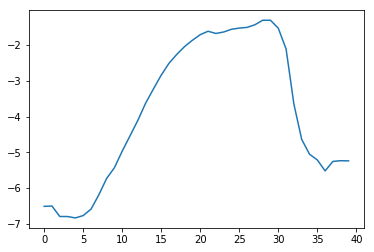

In [109]:
i=24
plt.plot(W[i,i,:])
print cell_types[i]
np.logspace()

In [68]:
print priors[cell_types[1]]['b_mean'], b[1]

-3.328787425468708 -3.3347363471984863


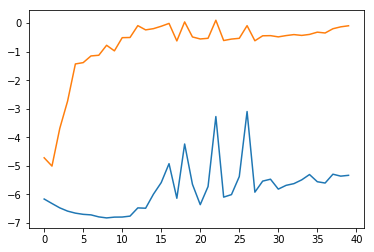

In [77]:
plt.plot(priors['inh_VISp_5']['W_means'].T)

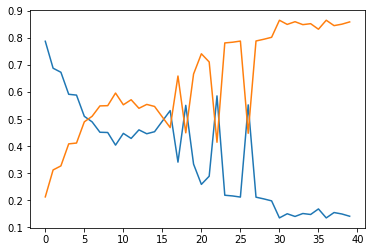

In [78]:
plt.plot(priors['inh_VISp_5']['W_weights'].T)

In [87]:
def evaluate_network(stimulus,spikes, d_stim, d_spk, models):
    N = spikes.shape[0]
    loss = 0
    Xdsn = construct_GLM_mat(stimulus,spikes, d_stim, d_spk)
    for i in range(N):
        y = spikes[i,max(d_stim,d_spk):]
        loss += models[i].evaluate(x=Xdsn, y=y, batch_size = 100000000, verbose=0)
        if loss is list:
            loss = loss[0]
    return loss

val_per_img = 40
num_correct = 0
n_img_val = 2
img_inds = np.argsort(np.bincount(stim_table[stim_table.frame>=0].frame.values[:num_stim_rows].astype(int)))[-n_img_val:]
print img_inds
for img in imgs[img_inds]:
    for i in range(val_per_img):
        t_start = stim_table[(stim_table.index>num_stim_rows) & (stim_table.frame==img)].start.values[i]
        t_end = stim_table[(stim_table.index>num_stim_rows) & (stim_table.frame==img)].end.values[i]
        (binned_spikes, _) = bin_spikes(data_set,bin_len,t_start,t_end,regions=['VISp'])
        reduced_binned_spikes = binned_spikes[cell_idxs[-k:],:]
        T = reduced_binned_spikes.shape[1]
        losses = []
        for check_img in imgs[img_inds]:
            flat_stimulus = np.tile(np.expand_dims(flattened_image_list[int(check_img)],1),(1,T)) #flatten check_img for the right number of time points
            losses.append(evaluate_network(flat_stimulus,reduced_binned_spikes,d,d,models))
        if imgs[img_inds[np.argmin(losses)]] == img:
            num_correct += 1
accuracy = num_correct*1.0/(val_per_img*n_img_val)
print accuracy

[61 90]
0.5


In [88]:
np.savez('net_fit_priors3',F=F,W=W,b=b,losses=losses,accuracy=accuracy)

In [ ]:
#kernel_regularizer=SparseGroupLasso(M*d_stim,d_spk,lgroup=0))

In [49]:
norms = np.linalg.norm(W[0], axis = 1)
norms.shape

(2,)

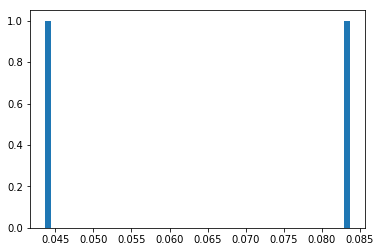

In [50]:
plt.hist(norms, bins = 50);

In [67]:
from statsmodels.stats.proportion import proportions_ztest
print 0.35*80
print proportions_ztest([28],[80],value=0.5)

28.0
(array([-2.81284339]), array([0.00491056]))


In [ ]:
# def construct_GLM_mat(flat_stimulus, binned_spikes, i, d_stim, d_spk):
#     (N,T) = binned_spikes.shape # N is number of neurons, T is number of time bins
#     print("T",T)
#     (M,T) = flat_stimulus.shape # M is the size of a stimulus
#     X_dsn = np.empty((T-d_stim+1,M*d_stim+N*d_spk))
#     d_max = max(d_stim,d_spk)
#     y = np.empty((T-d_max+1,))
#     for t in range(T-d_max+1):
#         y[t] = binned_spikes[i,t+d_max-1]
#         X_dsn[t,:M*d_stim] = flat_stimulus[:,t+d_max-d_stim:t+d_max].reshape((1,-1))
#         X_dsn[t,M*d_stim:] = binned_spikes[:,t+d_max-d_spk:t+d_max].reshape((1,-1))
#     return (y, X_dsn)   

In [ ]:
# import keras
# from keras import backend as K
# from keras.models import Model
# from keras.layers import Input
# from keras import Sequential
# from keras.layers import Dense, Lambda
# from keras.regularizers import Regularizer
# def GLM_network_fit(stimulus,spikes,d_stim, d_spk,bin_len,f='exp',priors=None,L1=None):
#     N = spikes.shape[0]
#     print("N", N)
#     M = stimulus.shape[0]
#     print("M", M)
#     F = np.empty((N,M,d_stim)) # stimulus filters
#     W = np.empty((N,N,d_spk))  # spike train filters
#     b = np.empty((N,)) # biases
#     fs = {'exp':K.exp}
#     for i in range(1):
#         [y, Xdsn] = construct_GLM_mat(np.array(stim_array), binned_spikes, i, d_stim, d_spk)
#         print("yshape",y.shape)
#         model = Sequential()
#         model.add(Dense(1,input_dim = Xdsn.shape[1],use_bias=True, kernel_regularizer=SparseGroupLasso(M*d_stim,d_spk,lgroup=1e-10)))
#         model.add(Lambda(lambda x: fs[f](x)*bin_len))
#         model.compile(loss = 'poisson',optimizer = keras.optimizers.adam(lr=5e-1))
#         model.fit(x=Xdsn,y=y,epochs=50, batch_size = 1000,  verbose=1)
#         p = model.get_weights()[0]
#         print("pshape", p.shape)
#         print("Mdstim", M*d_stim)
#         F[i,:,:] = p[:M*d_stim].reshape((M,d_stim))
#         W[i,:,:] = p[M*d_stim:].reshape((N,d_spk))
#         b[i] = model.get_weights()[1]
#     return (F,W,b)
